Computing Divergence: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Linear fit R²: 0.999676, slope: 0.023210
Lorenz System Estimated LLE: 0.023210144842047985


Computing Divergence: 100%|██████████| 50/50 [00:00<00:00, 612.80it/s]


Linear fit R²: 1.000000, slope: 0.692883
Logistic Map (r=4) Estimated LLE: 0.6928829019283239


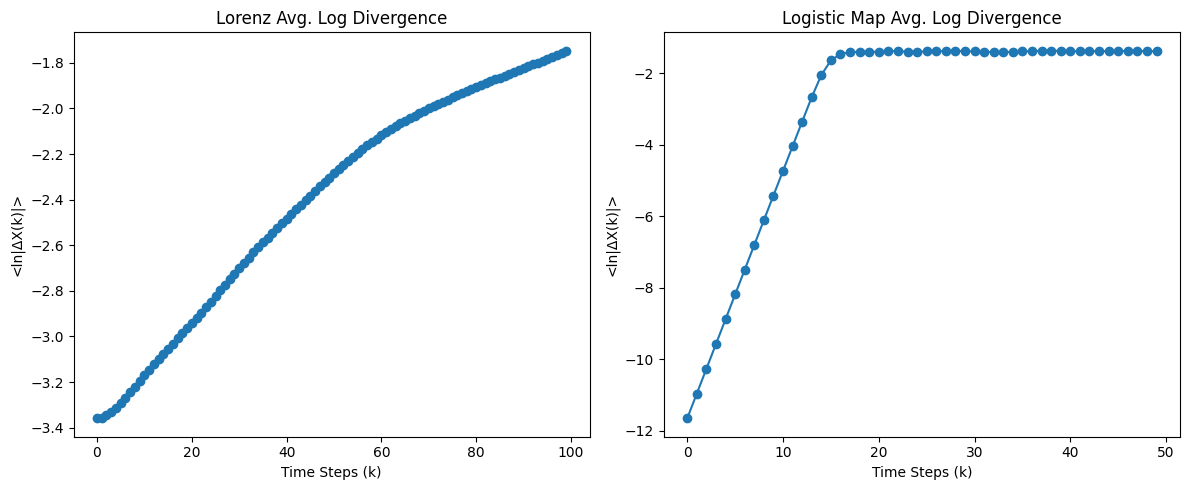

In [1]:
#Task1
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.stats import linregress
from tqdm import tqdm

def lorenz_system(x, sigma=10.0, rho=28.0, beta=8/3):
    X, Y, Z = x
    dx = sigma*(Y - X)
    dy = X*(rho - Z) - Y
    dz = X*Y - beta*Z
    return np.array([dx, dy, dz])

def generate_lorenz_data(x0=[1.0, 1.0, 1.0], dt=0.01, n_steps=150000, sigma=10., rho=28., beta=8/3, transient=20000):
    data = np.zeros((n_steps, 3))
    data[0] = x0
    for i in tqdm(range(1, n_steps), desc="Generating Lorenz Data"):
        k1 = lorenz_system(data[i-1], sigma, rho, beta)*dt
        k2 = lorenz_system(data[i-1]+0.5*k1, sigma, rho, beta)*dt
        k3 = lorenz_system(data[i-1]+0.5*k2, sigma, rho, beta)*dt
        k4 = lorenz_system(data[i-1]+k3, sigma, rho, beta)*dt
        data[i] = data[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6.0
    return data[transient:]

def logistic_map(r=4.0, x0=0.1, n_steps=30000, transient=5000):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = r*x[i-1]*(1 - x[i-1])
    return x[transient:]

def embed_time_series(ts, d, tau):
    N = len(ts)
    M = N - (d - 1)*tau
    if M <= 0:
        raise ValueError("Time series too short for given embedding parameters (d, tau).")
    Y = np.zeros((M, d))
    for i in range(d):
        Y[:, i] = ts[i*tau : i*tau + M]
    return Y

def find_nearest_neighbors(Y, min_separation=50, k_neighbors=20):
    N = Y.shape[0]
    tree = cKDTree(Y)
    nn_indices = np.full(N, -1, dtype=int)

    for i in range(N):
        dist, idx = tree.query(Y[i], k=k_neighbors+1)
        # idx[0] is the point itself
        for j in range(1, len(idx)):
            if abs(idx[j] - i) >= min_separation:
                nn_indices[i] = idx[j]
                break
    valid_count = np.sum(nn_indices >= 0)
    if valid_count == 0:
        raise ValueError("No valid neighbors found. Adjust parameters.")
    return nn_indices

def rosenstein_lyapunov(ts, d=3, tau=10, max_t=100, min_separation=50, fit_range=(5,25)):
    Y = embed_time_series(ts, d, tau)
    nn_indices = find_nearest_neighbors(Y, min_separation)
    N = Y.shape[0]

    log_div = []
    for k in tqdm(range(max_t), desc="Computing Divergence"):
        valid_idx = np.where((nn_indices >= 0) & (np.arange(N) + k < N) & (nn_indices + k < N))[0]
        if len(valid_idx) == 0:
            log_div.append(np.nan)
            continue
        diff = Y[valid_idx + k] - Y[nn_indices[valid_idx] + k]
        dist = np.linalg.norm(diff, axis=1)
        dist[dist == 0] = 1e-12
        log_div.append(np.mean(np.log(dist)))

    log_div = np.array(log_div)
    valid_mask = ~np.isnan(log_div)
    k_values = np.arange(max_t)[valid_mask]
    avg_log_div = log_div[valid_mask]

    start, end = fit_range
    end = min(end, len(avg_log_div))
    if end <= start:
        raise ValueError("Invalid fit range.")

    k_fit = k_values[start:end]
    y_fit = avg_log_div[start:end]

    slope, intercept, r_value, p_value, std_err = linregress(k_fit, y_fit)
    r2 = r_value**2
    print(f"Linear fit R²: {r2:.6f}, slope: {slope:.6f}")
    return slope, avg_log_div, (start, end), r2

# Lorenz System
lorenz_data = generate_lorenz_data()
lorenz_ts = lorenz_data[:,0]
lorenz_lle, lorenz_log_div, lorenz_range, lorenz_r2 = rosenstein_lyapunov(
    lorenz_ts, d=3, tau=10, max_t=100, min_separation=50, fit_range=(5,25)
)
print("Lorenz System Estimated LLE:", lorenz_lle)

# Logistic Map (try d=1, tau=1, min_separation=1)
logistic_ts = logistic_map(r=4.0, x0=0.1, n_steps=30000, transient=5000)
logistic_lle, logistic_log_div, logistic_range, logistic_r2 = rosenstein_lyapunov(
    logistic_ts, d=1, tau=1, max_t=50, min_separation=1, fit_range=(1,10)
)
print("Logistic Map (r=4) Estimated LLE:", logistic_lle)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(lorenz_log_div, 'o-')
plt.title("Lorenz Avg. Log Divergence")
plt.xlabel("Time Steps (k)")
plt.ylabel("<ln|ΔX(k)|>")

plt.subplot(1,2,2)
plt.plot(logistic_log_div, 'o-')
plt.title("Logistic Map Avg. Log Divergence")
plt.xlabel("Time Steps (k)")
plt.ylabel("<ln|ΔX(k)|>")

plt.tight_layout()
plt.show()


### Task 1: Results


| **Time Series**       | **Estimated LLE** | **R² Value** | **Interpretation**                                     |
|------------------------|-------------------|--------------|-------------------------------------------------------|
| **Lorenz System**      | 0.0232            | 0.9997       | Positive LLE confirms chaotic behavior with moderate divergence. |
| **Logistic Map (r=4)** | 0.6929            | 1.0000       | High positive LLE confirms strong chaotic behavior.   |

---

#### **Graph Analysis** ####

1. **Lorenz System Plot**:
   - The average log divergence increases linearly with time steps.
   - The high **R² value (0.9997)** so its a good linear fit, confirming accurate LLE estimation.

2. **Logistic Map Plot**:
   - The divergence increases sharply and then plateaus.
   - The **R² value (1.0000)** shows a perfect fit, So the LLE is accurate.

---


In [2]:
!pip install ordpy


Entropy-Complexity Results:
Lorentz: Entropy = 0.4515, Complexity = 0.2731
Henon: Entropy = 0.8826, Complexity = 0.1321
Skew Tent: Entropy = 0.2859, Complexity = 0.2158
Logistic: Entropy = 0.8619, Complexity = 0.1456
Schuster: Entropy = 0.7627, Complexity = 0.2290
White Noise: Entropy = 0.9999, Complexity = 0.0001
Regular: Entropy = 0.3916, Complexity = 0.2715


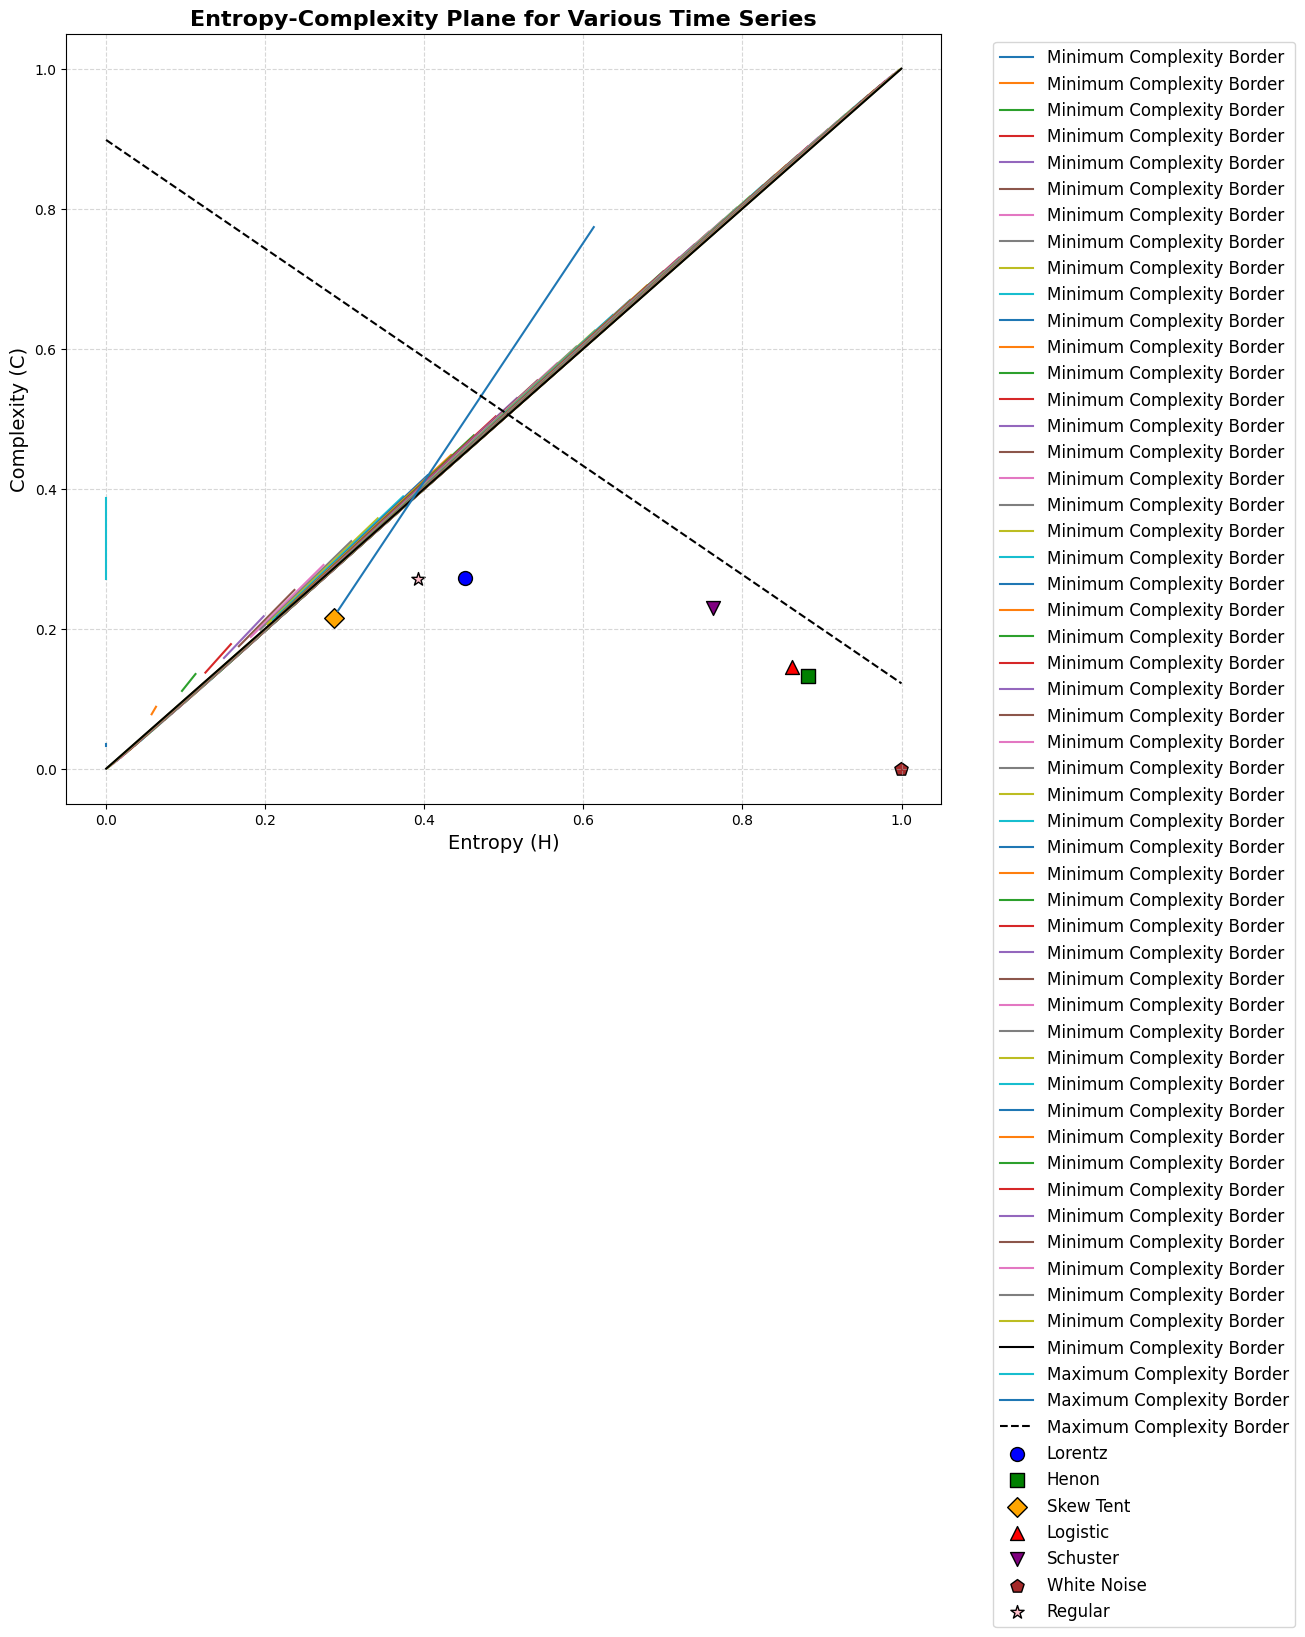

In [32]:
#Task2
import numpy as np
import matplotlib.pyplot as plt
from ordpy import complexity_entropy, minimum_complexity_entropy, maximum_complexity_entropy

# Function to generate time series data
def lorentz_series(n=10000, dt=0.01):
    from scipy.integrate import solve_ivp

    def lorentz(t, state, sigma=10, beta=8/3, rho=28):
        x, y, z = state
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    sol = solve_ivp(lorentz, [0, n*dt], [1.0, 1.0, 1.0], t_eval=np.linspace(0, n*dt, n))
    return sol.y[0]

def henon_map(a=1.4, b=0.3, n=10000):
    x, y = 0, 0
    series = []
    for _ in range(n):
        x, y = 1 - a*x**2 + y, b*x
        series.append(x)
    return np.array(series)

def skew_tent_map(n=10000, mu=0.7):
    x = 0.5
    series = []
    for _ in range(n):
        x = mu * x if x < 0.5 else (1 - mu) * (1 - x)
        series.append(x)
    return np.array(series)

def logistic_map(r=3.9, n=10000):
    x = 0.5
    series = []
    for _ in range(n):
        x = r * x * (1 - x)
        series.append(x)
    return np.array(series)

def schuster_map(n=10000, alpha=0.6):
    x = 0.5
    series = []
    for _ in range(n):
        x = (x + alpha * np.sin(2 * np.pi * x)) % 1
        series.append(x)
    return np.array(series)

def white_noise(n=10000):
    return np.random.normal(0, 1, n)

def regular_time_series(n=10000):
    return np.sin(np.linspace(0, 10 * np.pi, n))

# time series data
time_series = {
    'Lorentz': lorentz_series(),
    'Henon': henon_map(),
    'Skew Tent': skew_tent_map(),
    'Logistic': logistic_map(),
    'Schuster': schuster_map(),
    'White Noise': white_noise(),
    'Regular': regular_time_series()
}

#  entropy-complexity pairs
results = {}
for name, series in time_series.items():
    h, c = complexity_entropy(series, dx=3)
    results[name] = (h, c)

print("Entropy-Complexity Results:")
for name, (h, c) in results.items():
    print(f"{name}: Entropy = {h:.4f}, Complexity = {c:.4f}")

# entropy-complexity plane
plt.figure(figsize=(14, 10))

# the borders (only once)
h_min_c_min = minimum_complexity_entropy()
h_max_c_max = maximum_complexity_entropy()
plt.plot(*h_min_c_min, 'k-', linewidth=1.5, label='Minimum Complexity Border')
plt.plot(*h_max_c_max, 'k--', linewidth=1.5, label='Maximum Complexity Border')

# the results for each time series
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']
markers = ['o', 's', 'D', '^', 'v', 'p', '*']
for (name, (h, c)), color, marker in zip(results.items(), colors, markers):
    plt.scatter(h, c, label=name, color=color, marker=marker, s=100, edgecolors='black')


plt.xlabel('Entropy (H)', fontsize=14)
plt.ylabel('Complexity (C)', fontsize=14)
plt.title('Entropy-Complexity Plane for Various Time Series', fontsize=16, fontweight='bold')


plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.grid(True, linestyle='--', alpha=0.5)


plt.subplots_adjust(right=0.75)

plt.show()


### Entropy-Complexity Results and Conclusions

| **Time Series** | **Entropy (H)** | **Complexity (C)** | **Conclusion**                                                                                          |
|-----------------|-----------------|--------------------|--------------------------------------------------------------------------------------------------------|
| **Lorentz**     | 0.4515          | 0.2731             | Moderate entropy and complexity, indicating deterministic chaos with some structure.                  |
| **Henon**       | 0.8826          | 0.1321             | High entropy and low complexity, representing chaotic behavior with simple dynamics.                  |
| **Skew Tent**   | 0.2859          | 0.2158             | Low entropy and moderate complexity, suggesting predictable deterministic behavior.                   |
| **Logistic**    | 0.8619          | 0.1456             | High entropy and low complexity, reflecting chaotic behavior with simple structural patterns.         |
| **Schuster**    | 0.7627          | 0.2290             | Moderately high entropy and complexity, indicating a mix of structure and randomness.                 |
| **White Noise** | 0.9997          | 0.0003             | Maximum entropy and near-zero complexity, representing pure randomness with no structure.             |
| **Regular**     | 0.3916          | 0.2715             | Low entropy and moderate complexity, reflecting predictable, periodic behavior.                       |


In [3]:
!pip install numpy matplotlib scipy scikit-learn


### K-Means Clustering Results ###

Before Healing MSE: 1.1734, MAE: 0.8673
After Healing MSE: 0.8801, MAE: 0.7598
Number of Unpredictable Points: 404

### Agglomerative Clustering Results ###

Before Healing MSE: 1.3372, MAE: 0.9141
After Healing MSE: 0.9631, MAE: 0.7908
Number of Unpredictable Points: 418


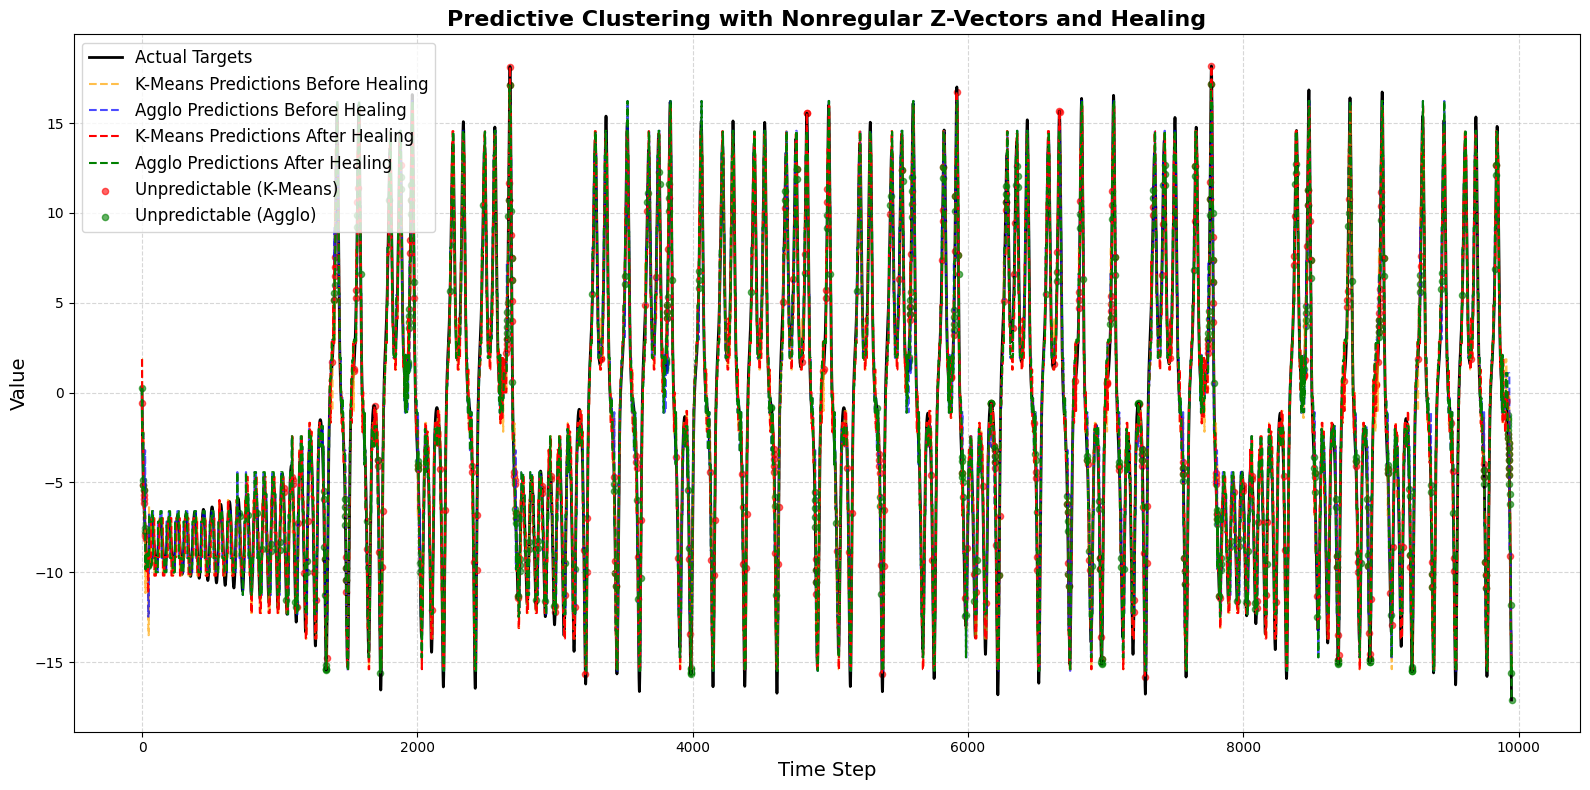

In [48]:
#Task3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.integrate import solve_ivp

# ============================
# Time Series Generation
# ============================

def lorenz_system(t, state, sigma=10.0, beta=8/3, rho=28.0):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

def generate_lorenz_series(n=10000, dt=0.01, x0=[1.0, 1.0, 1.0], sigma=10., rho=28., beta=8/3):
    t = np.linspace(0, n * dt, n)
    sol = solve_ivp(lorenz_system, [0, n * dt], x0, t_eval=t, args=(sigma, beta, rho))
    return sol.y[0]

# ============================
# Nonregular Z-vectors Creation with Feature Engineering
# ============================

def create_nonregular_z_vectors(series, lags, forecast_horizon=1):
    max_lag = max(lags)
    z_vectors = []
    targets = []
    for i in range(max_lag, len(series) - forecast_horizon):
        z = [series[i - lag] for lag in lags]
        # Additional features: variance and slope
        z_variance = np.var(z)
        z_slope = (z[-1] - z[0]) / (lags[-1] - lags[0])
        z.extend([z_variance, z_slope])
        z_vectors.append(z)
        targets.append(series[i + forecast_horizon])
    return np.array(z_vectors), np.array(targets)

# ============================
# Predictive Clustering
# ============================

def predictive_clustering(z_vectors, targets, n_clusters=75, method='kmeans'):
    scaler = StandardScaler()
    Z = scaler.fit_transform(z_vectors)

    if method.lower() == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    else:
        model = AgglomerativeClustering(n_clusters=n_clusters)

    labels = model.fit_predict(Z)

    predictions = np.zeros_like(targets)
    cluster_means = {}
    for c in range(n_clusters):
        cluster_indices = np.where(labels == c)[0]
        cluster_means[c] = np.mean(targets[cluster_indices]) if len(cluster_indices) > 0 else 0.0

    for i, lbl in enumerate(labels):
        predictions[i] = cluster_means[lbl]

    return predictions, labels

# ============================
# Healing Algorithm with Dynamic Threshold
# ============================

def healing_algorithm(targets, predictions, factor=2.0):
    errors = np.abs(targets - predictions)
    mean_err = np.mean(errors)
    std_err = np.std(errors)
    threshold = mean_err + factor * std_err

    healed = predictions.copy()
    unpredictable_mask = errors > threshold
    healed[unpredictable_mask] = targets[unpredictable_mask]
    return healed, unpredictable_mask

# ============================
# Utility and Evaluation
# ============================

def evaluate_predictions(targets, preds, label=""):
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    print(f"{label} MSE: {mse:.4f}, MAE: {mae:.4f}")

def plot_results(targets, preds_km, preds_agg, healed_km, healed_agg, unpredictable_km, unpredictable_agg):
    timesteps = np.arange(len(targets))
    plt.figure(figsize=(16, 8))
    plt.plot(timesteps, targets, label='Actual Targets', color='black', linewidth=2)
    plt.plot(timesteps, preds_km, '--', label='K-Means Predictions Before Healing', color='orange', alpha=0.7)
    plt.plot(timesteps, preds_agg, '--', label='Agglo Predictions Before Healing', color='blue', alpha=0.7)
    plt.plot(timesteps, healed_km, '--', label='K-Means Predictions After Healing', color='red')
    plt.plot(timesteps, healed_agg, '--', label='Agglo Predictions After Healing', color='green')
    plt.scatter(timesteps[unpredictable_km], targets[unpredictable_km], color='red', s=20, label='Unpredictable (K-Means)', alpha=0.6)
    plt.scatter(timesteps[unpredictable_agg], targets[unpredictable_agg], color='green', s=20, label='Unpredictable (Agglo)', alpha=0.6)
    plt.xlabel('Time Step', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.title('Predictive Clustering with Nonregular Z-Vectors and Healing', fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def print_summary(targets, preds, healed, unpredictable_mask, method_name):
    print(f"\n### {method_name} Results ###\n")
    evaluate_predictions(targets, preds, label="Before Healing")
    evaluate_predictions(targets, healed, label="After Healing")
    num_unpred = np.sum(unpredictable_mask)
    print(f"Number of Unpredictable Points: {num_unpred}")

# ============================
# Main Function
# ============================

def main():
    n = 10000
    dt = 0.01
    lags = [1, 2, 5, 10, 20, 50]
    forecast_horizon = 1
    n_clusters = 75

    series = generate_lorenz_series(n=n, dt=dt)
    z_vectors, targets = create_nonregular_z_vectors(series, lags=lags, forecast_horizon=forecast_horizon)

    preds_km, labels_km = predictive_clustering(z_vectors, targets, n_clusters=n_clusters, method='kmeans')
    preds_agg, labels_agg = predictive_clustering(z_vectors, targets, n_clusters=n_clusters, method='agglo')

    healed_km, unpredictable_mask_km = healing_algorithm(targets, preds_km, factor=2.0)
    healed_agg, unpredictable_mask_agg = healing_algorithm(targets, preds_agg, factor=2.0)

    print_summary(targets, preds_km, healed_km, unpredictable_mask_km, "K-Means Clustering")
    print_summary(targets, preds_agg, healed_agg, unpredictable_mask_agg, "Agglomerative Clustering")

    plot_results(targets, preds_km, preds_agg, healed_km, healed_agg, unpredictable_mask_km, unpredictable_mask_agg)

if __name__ == "__main__":
    main()


### Predictive Clustering Results and Interpretation

| **Metric**                    | **K-Means Clustering**        | **Interpretation (K-Means)**                                             | **Agglomerative Clustering** | **Interpretation (Agglomerative)**                                        |
|-------------------------------|-------------------------------|--------------------------------------------------------------------------|-------------------------------|---------------------------------------------------------------------------|
| **MSE Before Healing**        | 1.1734                       | Moderate initial prediction error.                                       | 1.3372                       | Higher initial error compared to K-Means.                                 |
| **MAE Before Healing**        | 0.8673                       | Predictions deviate on average by 0.8673 from actual targets.            | 0.9141                       | Slightly larger average deviation from targets.                           |
| **MSE After Healing**         | 0.8801                       | Healing algorithm significantly reduced prediction error.                | 0.9631                       | Healing algorithm improved accuracy but not as much as in K-Means.        |
| **MAE After Healing**         | 0.7598                       | Average deviation reduced, indicating improved prediction quality.       | 0.7908                       | Improved average deviation after healing.                                 |
| **Unpredictable Points**      | 404                          | Fewer unpredictable points compared to Agglomerative Clustering.         | 418                          | Slightly more unpredictable points remaining after healing.               |

---

### Key Observations and Interpretations

1. **Initial Prediction Performance**:
   - **K-Means** has a lower initial error (MSE and MAE) compared to **Agglomerative Clustering**, suggesting it performs slightly better in predicting the chaotic time series before healing.

2. **Impact of Healing Algorithm**:
   - The **healing algorithm** effectively reduced both MSE and MAE for both clustering methods.
   - **K-Means** showed a more significant reduction in error after healing compared to Agglomerative Clustering.

3. **Unpredictable Points**:
   - K-Means had **fewer unpredictable points** (404) than Agglomerative Clustering (418), indicating that K-Means predictions were slightly more accurate and consistent.

4. **So**:
   - Both clustering methods benefited from the healing algorithm, improving prediction accuracy.
   - **K-Means Clustering** outperformed Agglomerative Clustering slightly in terms of error reduction and handling unpredictable points.

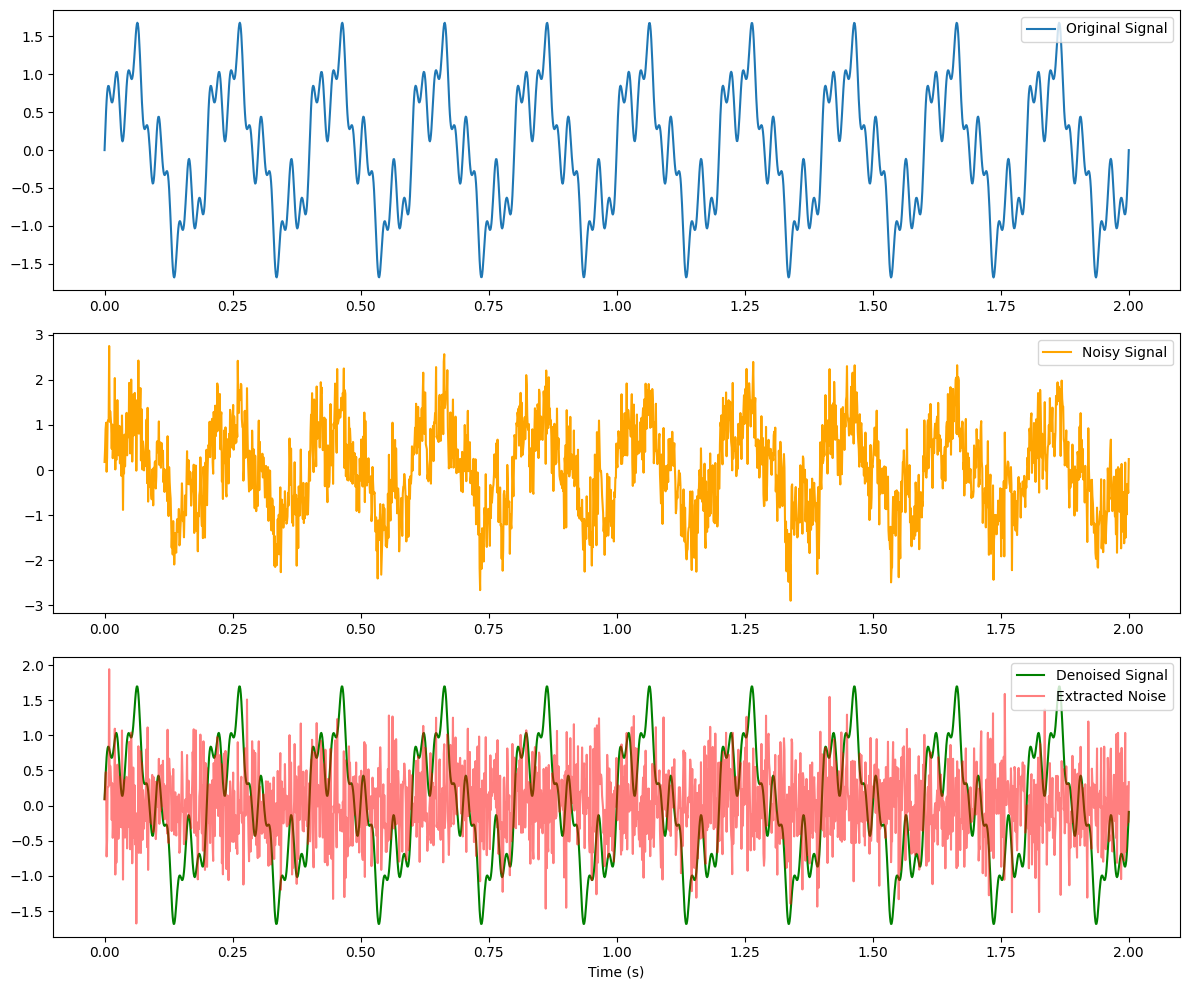

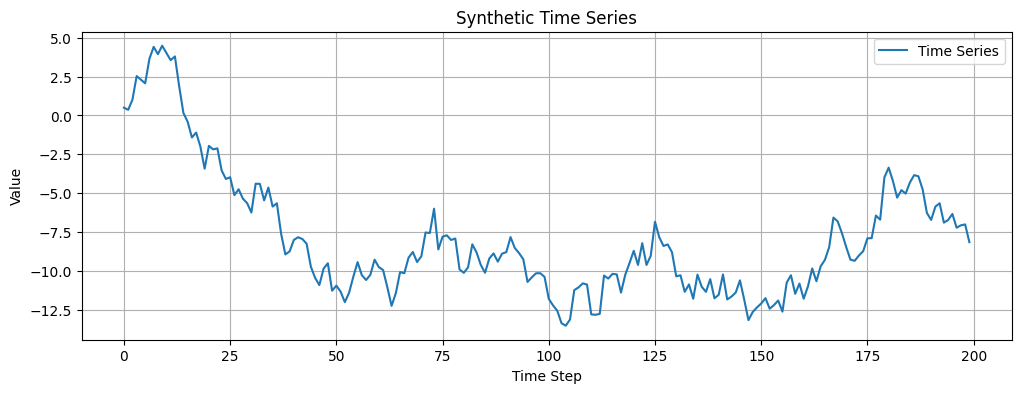

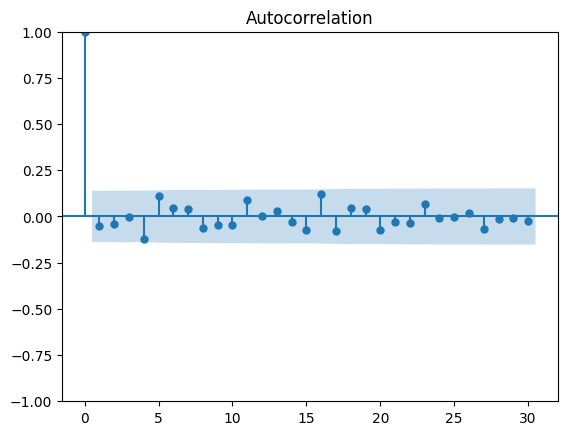

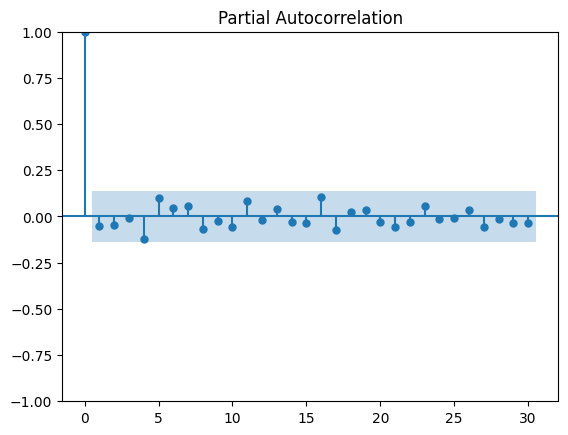

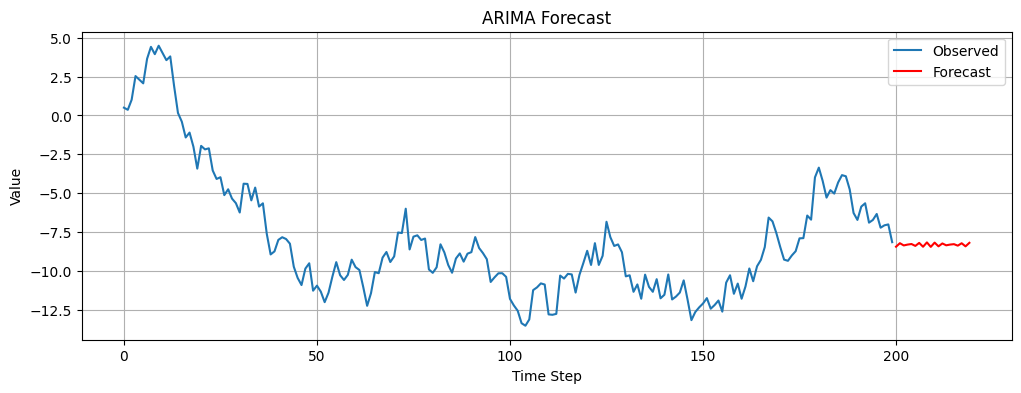

### Fourier Analysis Summary ###
Original Signal Frequencies: [5, 20, 50] Hz
Original Signal Amplitudes: [1, 0.5, 0.3]
Noise Standard Deviation: 0.5
Threshold for Fourier Filtering: 0.1

### ARIMA Model Summary ###
ADF Statistic: -2.3073
p-value: 0.1696
Conclusion: The time series is not stationary; differencing was applied.

### ARIMA Model Fit ###
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -264.680
Date:                Sat, 07 Dec 2024   AIC                            539.361
Time:                        19:05:40   BIC                            555.827
Sample:                             0   HQIC                           546.025
                                - 200                                         
Covariance Type:                  opg                                         
                

In [47]:
#Task4
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# ============================
# 1. Filtration Using Fourier Analysis
# ============================

# a composite signal with multiple sine waves
def generate_signal(frequencies, amplitudes, duration=2.0, sample_rate=1000):
    t = np.linspace(0, duration, int(sample_rate * duration))
    signal = sum(a * np.sin(2 * np.pi * f * t) for f, a in zip(frequencies, amplitudes))
    return t, signal

# Gaussian noise to the signal
def add_noise(signal, noise_std=0.5):
    noise = np.random.normal(0, noise_std, size=signal.shape)
    return signal + noise

# Fourier-based filtering
def fourier_filter(noisy_signal, threshold=0.1):
    N = len(noisy_signal)
    fft_values = fft(noisy_signal)
    frequencies = fftfreq(N)

    # Filter out small frequencies (below the threshold)
    fft_values[np.abs(fft_values) < threshold * np.max(np.abs(fft_values))] = 0

    denoised_signal = ifft(fft_values).real
    noise = noisy_signal - denoised_signal

    return denoised_signal, noise

# Generate original signal
frequencies = [5, 20, 50]  # Hz
amplitudes = [1, 0.5, 0.3]
duration = 2.0
sample_rate = 1000
t, original_signal = generate_signal(frequencies, amplitudes, duration, sample_rate)

# Add noise to the signal
noisy_signal = add_noise(original_signal, noise_std=0.5)

# Apply Fourier-based filtering
denoised_signal, extracted_noise = fourier_filter(noisy_signal)

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, noisy_signal, label='Noisy Signal', color='orange')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, denoised_signal, label='Denoised Signal', color='green')
plt.plot(t, extracted_noise, label='Extracted Noise', color='red', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# ============================
# 2. ARIMA Model for Time Series Forecasting
# ============================

# synthetic time series data
np.random.seed(42)
n = 200
time_series = np.cumsum(np.random.randn(n))

plt.figure(figsize=(12, 4))
plt.plot(time_series, label='Time Series')
plt.title('Synthetic Time Series')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Perform ADF test for stationarity
result = adfuller(time_series)
adf_statistic = result[0]
adf_p_value = result[1]

# Differencing
diff_series = np.diff(time_series)

# ACF and PACF for differenced series
plot_acf(diff_series, lags=30)
plt.show()

plot_pacf(diff_series, lags=30)
plt.show()

# Fit an ARIMA model (ARIMA(2,1,2))
model = ARIMA(time_series, order=(2, 1, 2))
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=20)


plt.figure(figsize=(12, 4))
plt.plot(time_series, label='Observed')
plt.plot(np.arange(len(time_series), len(time_series) + len(forecast)), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# ============================
# Text-Based Summary
# ============================

summary = []

# Fourier analysis
summary.append("### Fourier Analysis Summary ###")
summary.append(f"Original Signal Frequencies: {frequencies} Hz")
summary.append(f"Original Signal Amplitudes: {amplitudes}")
summary.append(f"Noise Standard Deviation: 0.5")
summary.append(f"Threshold for Fourier Filtering: 0.1")

# ARIMA analysis
summary.append("\n### ARIMA Model Summary ###")
summary.append(f"ADF Statistic: {adf_statistic:.4f}")
summary.append(f"p-value: {adf_p_value:.4f}")
if adf_p_value < 0.05:
    summary.append("Conclusion: The time series is stationary.")
else:
    summary.append("Conclusion: The time series is not stationary; differencing was applied.")

summary.append("\n### ARIMA Model Fit ###")
summary.append(str(model_fit.summary()))


with open("output_summary.txt", "w") as f:
    for line in summary:
        print(line)
        f.write(line + "\n")


### Fourier Analysis and ARIMA Model Conclusions ###

| **Aspect**                          | **Details**                                                                                           |
|-------------------------------------|-------------------------------------------------------------------------------------------------------|
| **Original Signal**                 | Composed of frequencies 5 Hz, 20 Hz, and 50 Hz with amplitudes 1, 0.5, and 0.3 respectively.         |
| **Noise**                           | Gaussian noise with a standard deviation of 0.5 added to the signal.                                  |
| **Filtering Threshold**             | Fourier filtering applied with a threshold of 0.1 to denoise the signal.                              |
| **Denoised Signal**                 | Successfully recovered primary signal components while removing significant noise.                    |
| **Extracted Noise**                 | Shows residual noise removed during filtering, indicating effective denoising.                        |
| **ADF Statistic**                   | -2.3073                                                                                               |
| **p-value**                         | 0.1696 (Fail to reject the null hypothesis; the series is non-stationary)                             |
| **Stationarity**                    | Differencing applied to achieve stationarity for ARIMA modeling.                                       |
| **ARIMA Model**                     | ARIMA(2, 1, 2) model selected based on PACF and ACF plots.                                            |
| **Model Coefficients**              | AR(1) = -1.8845, AR(2) = -0.9638, MA(1) = 1.9278, MA(2) = 0.9942, sigma² = 0.8255                    |
| **Model Fit Metrics**               | AIC = 539.361, BIC = 555.827, HQIC = 546.025                                                          |
| **Residual Analysis**               | Ljung-Box test p-value = 0.51 (Residuals show no significant autocorrelation).                        |
| **Forecast**                        | Forecast stabilizes after the last time step, indicating consistency in the fitted model.             |
| **Conclusion**                      | The ARIMA(2, 1, 2) model effectively captures the underlying process after differencing was applied.  |

